In [306]:
import pandas as pd
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb

In [21]:
df = pd.read_csv('NIFTY 100_minute.csv',parse_dates = ['date'])

In [13]:
df.isna().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [29]:
df['Date only'] = df.date.dt.date

In [59]:
df = df.set_index(df['date'], drop = True)

In [61]:
df

,date,open,high,low,close,volume,Date only
date,,,,,,,
2015-01-09 09:15:00,2015-01-09 09:15:00,8300.60,8309.75,8300.60,8308.35,0,2015-01-09
2015-01-09 09:16:00,2015-01-09 09:16:00,8308.35,8308.65,8304.05,8304.20,0,2015-01-09
2015-01-09 09:17:00,2015-01-09 09:17:00,8304.20,8308.20,8304.00,8308.20,0,2015-01-09
2015-01-09 09:18:00,2015-01-09 09:18:00,8308.20,8315.30,8308.20,8315.30,0,2015-01-09
2015-01-09 09:19:00,2015-01-09 09:19:00,8315.30,8316.10,8314.85,8316.10,0,2015-01-09
...,...,...,...,...,...,...,...
2025-07-25 15:25:00,2025-07-25 15:25:00,25443.50,25444.65,25440.95,25443.00,0,2025-07-25
2025-07-25 15:26:00,2025-07-25 15:26:00,25443.00,25445.35,25437.25,25439.00,0,2025-07-25
2025-07-25 15:27:00,2025-07-25 15:27:00,25439.00,25439.00,25431.25,25434.00,0,2025-07-25


In [123]:
df_daily = df.resample("d").agg({'open':'first', 'high': 'max', 'low': 'min', 'close':'last'})

In [135]:
df_daily.head(50)

,open,high,low,close
date,,,,
2015-01-09,8300.60,8317.25,8209.70,8287.75
2015-01-10,NaN,NaN,NaN,NaN
2015-01-11,NaN,NaN,NaN,NaN
2015-01-12,8295.95,8334.95,8254.00,8330.45
2015-01-13,8350.80,8362.70,8275.25,8310.70
2015-01-14,8315.50,8335.95,8247.40,8295.80
2015-01-15,8428.65,8519.40,8391.80,8453.85
2015-01-16,NaN,NaN,NaN,NaN
2015-01-17,NaN,NaN,NaN,NaN


In [129]:
df_daily.isna().sum()

open     1240
high     1240
low      1240
close    1240
dtype: int64

In [156]:
df_daily_dropped = df_daily.dropna()

In [137]:
df_daily[df_daily.isna().any(axis=1)].head()


,open,high,low,close
date,,,,
2015-01-10,NaN,NaN,NaN,NaN
2015-01-11,NaN,NaN,NaN,NaN
2015-01-16,NaN,NaN,NaN,NaN
2015-01-17,NaN,NaN,NaN,NaN
2015-01-18,NaN,NaN,NaN,NaN


<Axes: title={'center': 'Close price hourly'}, xlabel='date'>

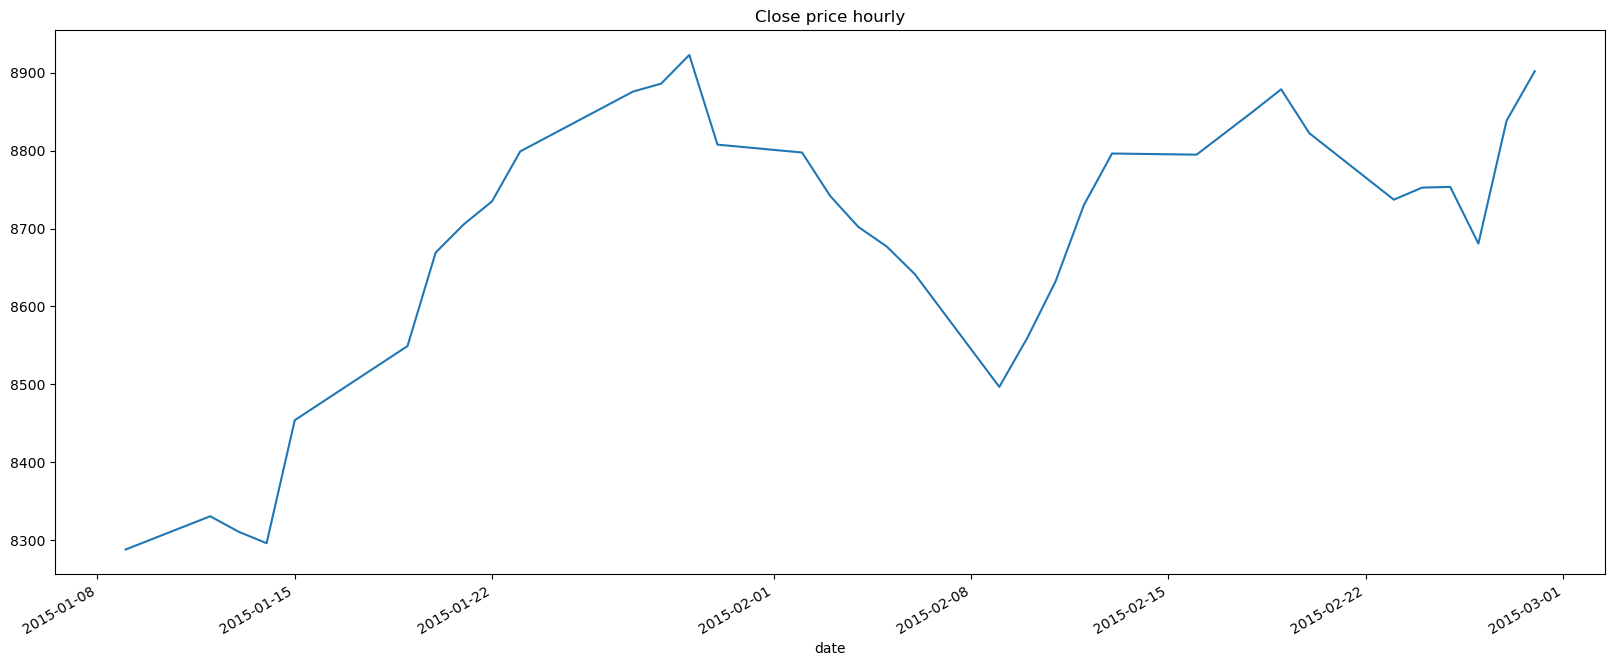

In [158]:
df_daily_dropped.loc['2015-01-1':'2015-02-28','close'].plot(
    figsize = (20,8),
    title = "Close price hourly"
)

Technical indicators are crucial tools in financial analysis, we are gonna use just some of the most famous ones.¶

Simple Moving Average (SMA): Averages the closing prices over a specified window, smoothing out price fluctuations and highlighting trends.

Exponential Moving Average (EMA): Similar to SMA, EMA gives more weight to recent prices, making it sensitive to short-term price movements.

Moving Average Convergence Divergence (MACD): Represents the difference between short-term EMA and long-term EMA, providing insights into the strength and direction of a trend.

Relative Strength Index (RSI): Measures the speed and change of price movements, indicating overbought or oversold conditions in the market.

Bollinger Bands: Consist of a middle band (SMA) and upper/lower bands representing price volatility. They help identify price extremes and potential reversal points.

In [246]:
def SMA(data, window_size):
    return data['close'].rolling(window=window_size).mean()

def EMA(data, window_size):
    return data['close'].ewm(span=window_size).mean()

def MACD(data, short_window, long_window):
    short_EMA = EMA(data, short_window)
    long_EMA = EMA(data, long_window)
    return short_EMA - long_EMA

def RSI(data, window_size):
    delta = data['close'].diff()
    delta = delta[1:] 
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=window_size-1 , min_periods=window_size).mean()
    ema_down = down.ewm(com=window_size-1 , min_periods=window_size).mean()
    return ema_up/ema_down

def Bollinger_Bands(data, window_size):
    middle_band = SMA(data, window_size)
    std_dev = data['close'].rolling(window=window_size).std()
    upper_band = middle_band + (std_dev*2)
    lower_band = middle_band - (std_dev*2)
    return upper_band, lower_band

In [160]:
def check_stationarity(series):
    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [170]:
def date_features(df):
    # Create time series features based on time series index.
    df.index = pd.to_datetime(df.index)
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [168]:
check_stationarity(df_daily_dropped['close'])

ADF Statistic: 0.406222
p-value: 0.981726
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Non-stationary


In [188]:
check_stationarity(df_daily_dropped.close.diff(periods=1).dropna())

ADF Statistic: -12.897125
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


In [198]:
df_daily_dropped["close_diff_1"] = df_daily_dropped.close.diff(periods = 1)

C:\Users\auguz\AppData\Local\Temp\ipykernel_25352\1969973625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_dropped["close_diff_1"] = df_daily_dropped.close.diff(periods = 1)


In [202]:
df = date_features(df_daily_dropped)

In [204]:
df

,open,high,low,close,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,,
2015-01-09,8300.60,8317.25,8209.70,8287.75,NaN,4,1,1,2015,9,9,2
2015-01-12,8295.95,8334.95,8254.00,8330.45,42.70,0,1,1,2015,12,12,3
2015-01-13,8350.80,8362.70,8275.25,8310.70,-19.75,1,1,1,2015,13,13,3
2015-01-14,8315.50,8335.95,8247.40,8295.80,-14.90,2,1,1,2015,14,14,3
2015-01-15,8428.65,8519.40,8391.80,8453.85,158.05,3,1,1,2015,15,15,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-21,25652.95,25765.25,25535.50,25749.85,129.90,0,3,7,2025,202,21,30
2025-07-22,25822.90,25832.20,25686.25,25709.70,-40.15,1,3,7,2025,203,22,30
2025-07-23,25778.15,25857.00,25708.80,25837.10,127.40,2,3,7,2025,204,23,30


<Axes: xlabel='date'>

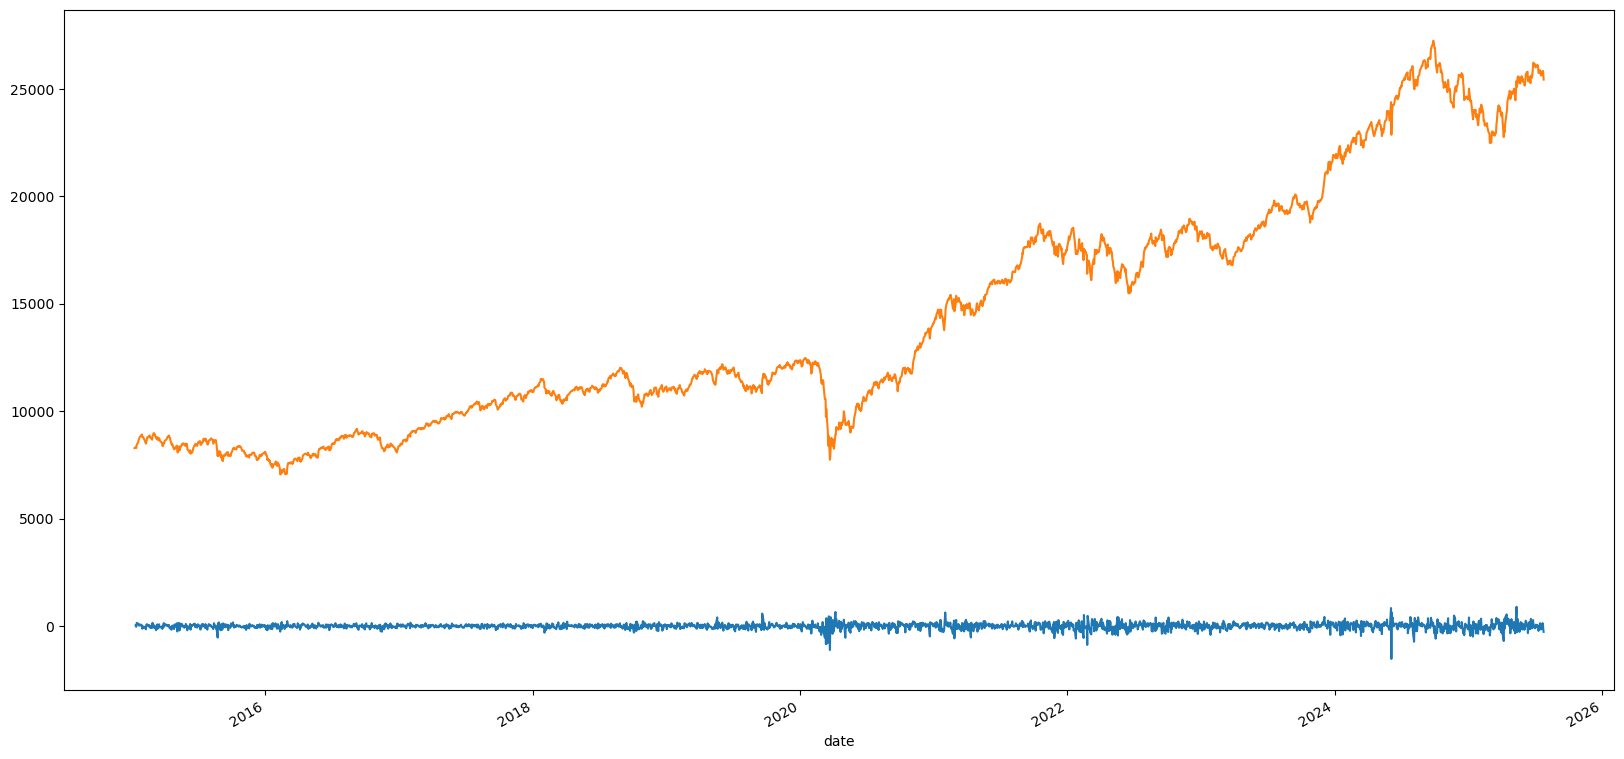

In [208]:
fig, ax = plt.subplots(    figsize = (20,10)
)
df.close_diff_1.plot(
    ax = ax
)
df.close.plot(
    ax = ax
)


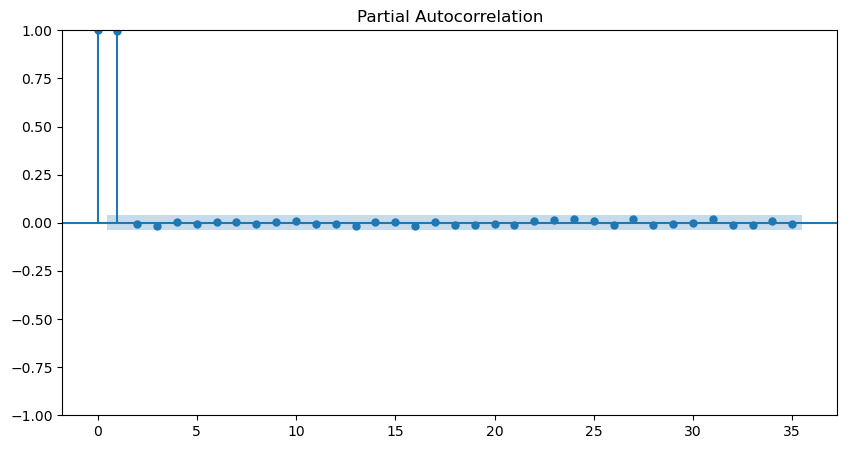

In [238]:
plot_pacf(df['close'])
plt.show()

In [240]:
# Significant autocorrelation at lag 1, therefore we introduce a feature representing the first lag
df["close(-1)"] = df.close.shift(1)

In [248]:
# adding indicators (kaggle tuto for the params)

df['SMA'] = SMA(df, 13)
df['EMA'] = EMA(df, 9) 
df['MACD'] = MACD(df, 24, 52)
df['RSI'] = RSI(df, 14)
df['Upper_Band'], df['Lower_Band'] = Bollinger_Bands(df, 10)

In [252]:
# creating new features in order to reduce multicolinearity

df["H_L_diff"] = df["high"] - df["low"]
df.drop("high", axis=1, inplace=True)
df.drop("low", axis=1, inplace=True)
df["Bands_diff"] = df["Upper_Band"] - df["Lower_Band"]
df.drop("Upper_Band", axis=1, inplace=True)
df.drop("Lower_Band", axis=1, inplace=True)


In [266]:
df["target"] = df["close"].shift(-1) #price of next day (effectively using 2 lags?)

In [264]:
df

,open,close,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,close(-1),SMA,EMA,MACD,RSI,H_L_diff,Bands_diff,target
date,,,,,,,,,,,,,,,,,,
2015-01-09,8300.60,8287.75,NaN,4,1,1,2015,9,9,2,NaN,NaN,8287.750000,0.000000,NaN,107.55,NaN,8330.45
2015-01-12,8295.95,8330.45,42.70,0,1,1,2015,12,12,3,8287.75,NaN,8311.472222,0.479006,NaN,80.95,NaN,8310.70
2015-01-13,8350.80,8310.70,-19.75,1,1,1,2015,13,13,3,8330.45,NaN,8311.155738,0.323989,NaN,87.45,NaN,8295.80
2015-01-14,8315.50,8295.80,-14.90,2,1,1,2015,14,14,3,8310.70,NaN,8305.953930,-0.014206,NaN,88.55,NaN,8453.85
2015-01-15,8428.65,8453.85,158.05,3,1,1,2015,15,15,3,8295.80,NaN,8349.949667,2.792628,NaN,127.60,NaN,8549.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-21,25652.95,25749.85,129.90,0,3,7,2025,202,21,30,25619.95,25895.230769,25807.306022,280.500332,0.969083,229.75,644.948881,25709.70
2025-07-22,25822.90,25709.70,-40.15,1,3,7,2025,203,22,30,25749.85,25873.330769,25787.784818,266.308977,0.918798,145.95,534.156494,25837.10
2025-07-23,25778.15,25837.10,127.40,2,3,7,2025,204,23,30,25709.70,25855.257692,25797.647854,258.326112,1.096113,148.20,390.985140,25691.80


In [272]:
tss = TimeSeriesSplit(n_splits = 8, test_size = 182, gap = 2)


train_idx : [   0    1    2 ... 1150 1151 1152], test_idx: [1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167 1168
 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182
 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195 1196
 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207 1208 1209 1210
 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223 1224
 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237 1238
 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249 1250 1251 1252
 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263 1264 1265 1266
 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279 1280
 1281 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294
 1295 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305 1306 1307 1308
 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322
 1323 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336]
train_idx : [   0

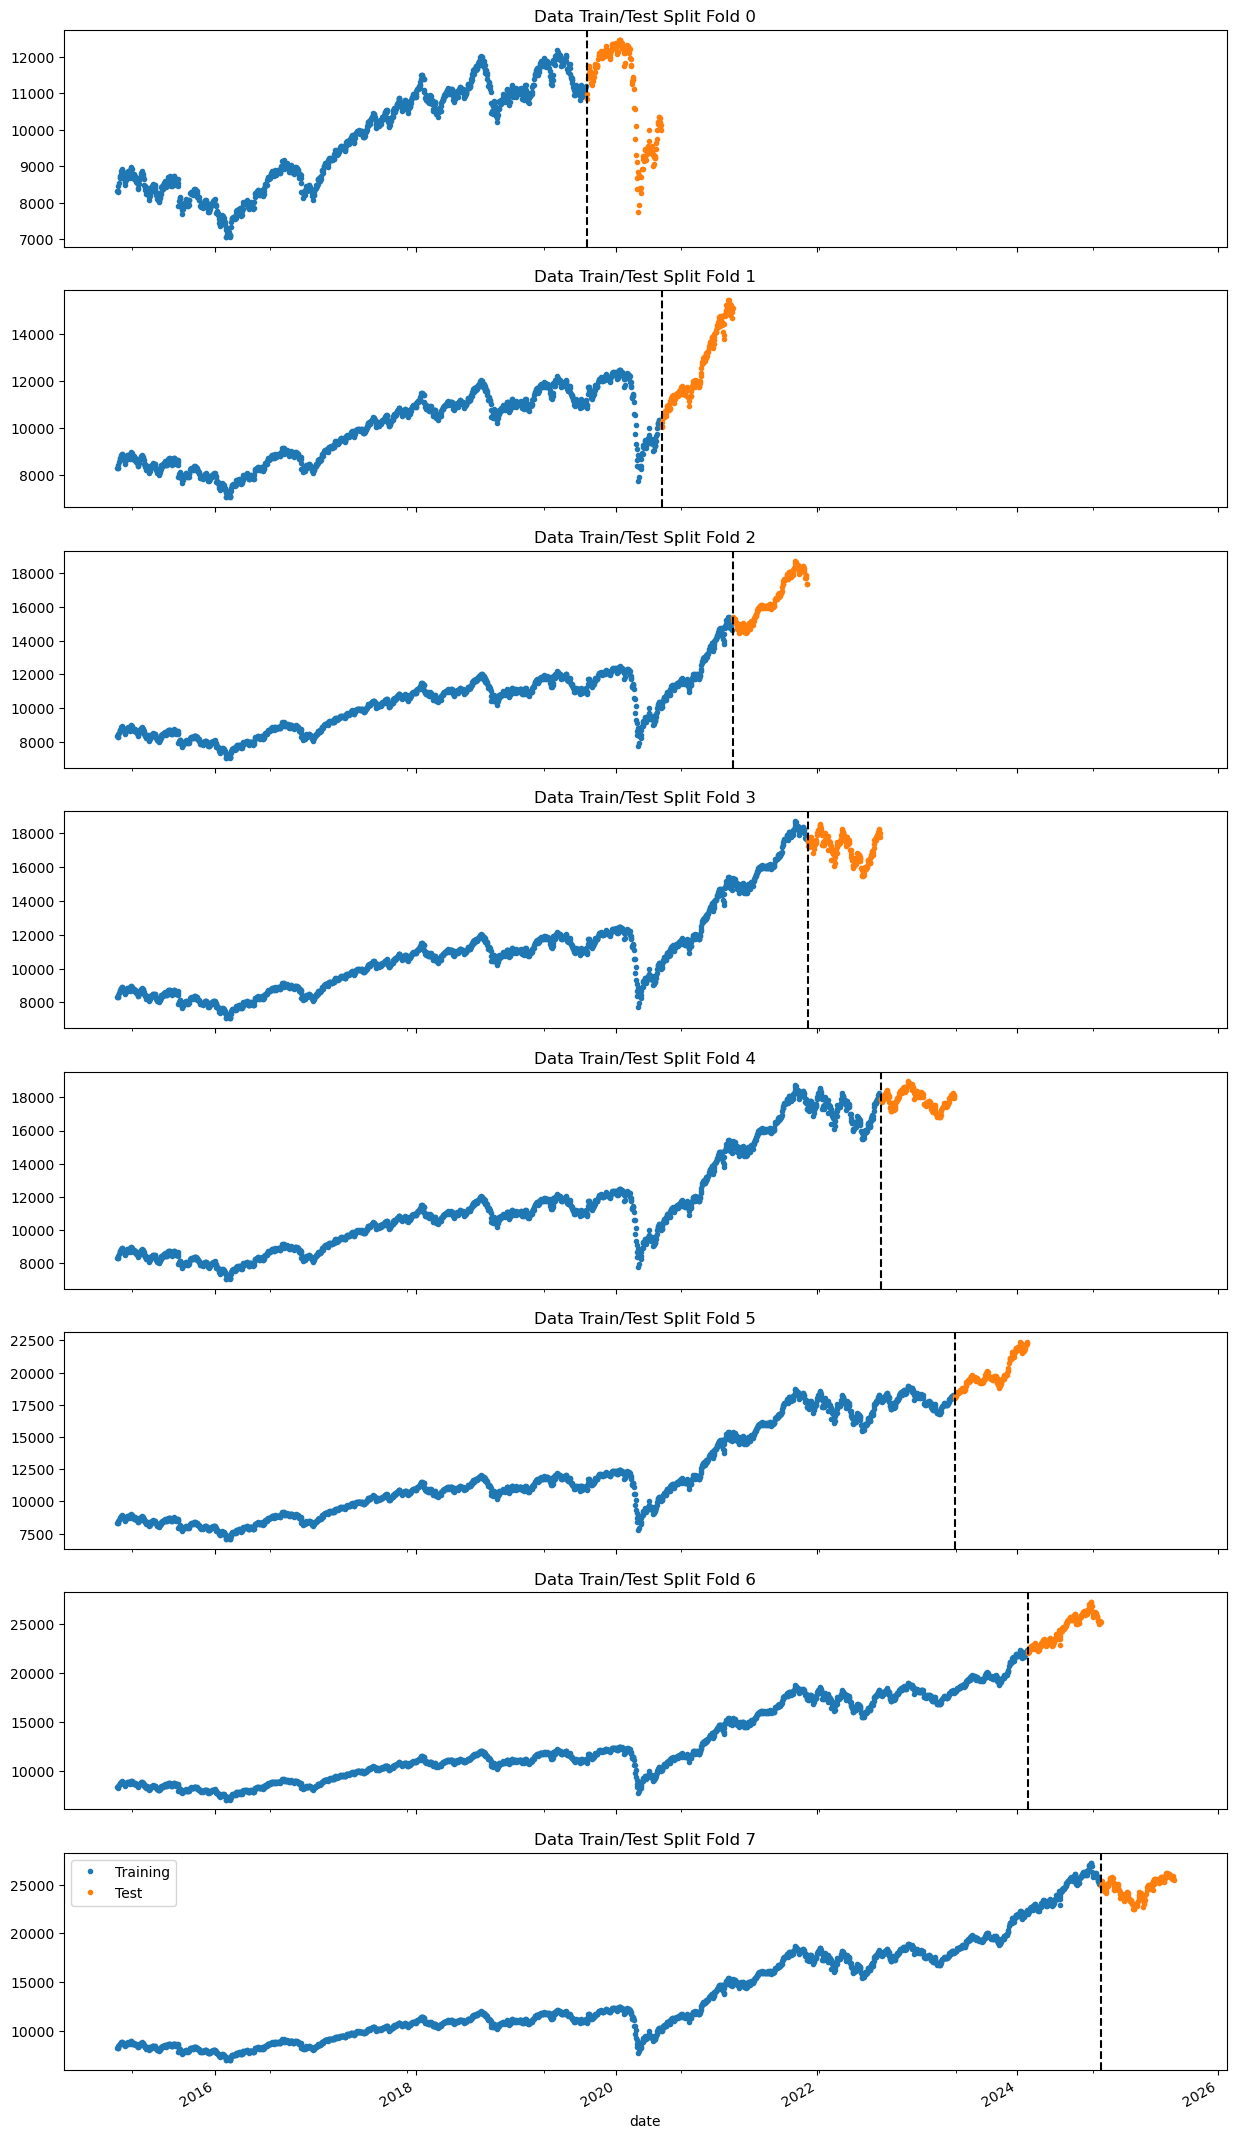

In [278]:
fig, axs = plt.subplots(8,1,figsize=(15,30),
                      sharex = True
                       )

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['target'].plot(ax = axs[fold],
                          style = '.', 
                           title = f'Data Train/Test Split Fold {fold}'
       )
    test['target'].plot(ax = axs[fold],
                          style = '.', 
       )    
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold+=1
    plt.legend(['Training', 'Test'])
    print(f"train_idx : {train_idx}, test_idx: {val_idx}")

In [282]:
splits = list(tss.split(df))

In [290]:
train_full_idx, test_full_idx = splits[-1] # use this to actually test the fit later on
train_full = df.iloc[train_full_idx]
test_full = df.iloc[test_full_idx]

In [292]:
train_full

,open,close,close_diff_1,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,close(-1),SMA,EMA,MACD,RSI,H_L_diff,Bands_diff,target
date,,,,,,,,,,,,,,,,,,
2015-01-09,8300.60,8287.75,NaN,4,1,1,2015,9,9,2,NaN,NaN,8287.750000,0.000000,NaN,107.55,NaN,8330.45
2015-01-12,8295.95,8330.45,42.70,0,1,1,2015,12,12,3,8287.75,NaN,8311.472222,0.479006,NaN,80.95,NaN,8310.70
2015-01-13,8350.80,8310.70,-19.75,1,1,1,2015,13,13,3,8330.45,NaN,8311.155738,0.323989,NaN,87.45,NaN,8295.80
2015-01-14,8315.50,8295.80,-14.90,2,1,1,2015,14,14,3,8310.70,NaN,8305.953930,-0.014206,NaN,88.55,NaN,8453.85
2015-01-15,8428.65,8453.85,158.05,3,1,1,2015,15,15,3,8295.80,NaN,8349.949667,2.792628,NaN,127.60,NaN,8549.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-23,25266.40,25320.55,-44.00,2,4,10,2024,297,23,43,25364.55,25887.153846,25750.882645,59.344882,0.448733,251.05,1270.806733,25291.00
2024-10-24,25315.05,25291.00,-29.55,3,4,10,2024,298,24,43,25320.55,25850.753846,25658.906116,24.860838,0.439210,158.90,1404.399371,25051.90
2024-10-25,25305.30,25051.90,-239.10,4,4,10,2024,299,25,43,25291.00,25771.046154,25537.504893,-15.847710,0.370662,429.40,1607.384822,25195.35


[0]	validation_0-rmse:1364.07532	validation_1-rmse:1885.02582
[100]	validation_0-rmse:518.69852	validation_1-rmse:870.25426
[200]	validation_0-rmse:209.39885	validation_1-rmse:490.05385
[300]	validation_0-rmse:105.56031	validation_1-rmse:353.21448
[400]	validation_0-rmse:77.81257	validation_1-rmse:313.84424
[500]	validation_0-rmse:70.45701	validation_1-rmse:298.85141
[600]	validation_0-rmse:67.47116	validation_1-rmse:294.04029
[700]	validation_0-rmse:65.56960	validation_1-rmse:292.29531
[800]	validation_0-rmse:64.04917	validation_1-rmse:291.63997
[890]	validation_0-rmse:62.81004	validation_1-rmse:291.70756
[0]	validation_0-rmse:1434.76651	validation_1-rmse:3032.22966
[100]	validation_0-rmse:548.64497	validation_1-rmse:1962.01502
[200]	validation_0-rmse:228.36458	validation_1-rmse:1561.32213
[300]	validation_0-rmse:126.02480	validation_1-rmse:1408.36586
[400]	validation_0-rmse:99.41773	validation_1-rmse:1343.36974
[500]	validation_0-rmse:92.00068	validation_1-rmse:1317.98988
[600]	valid

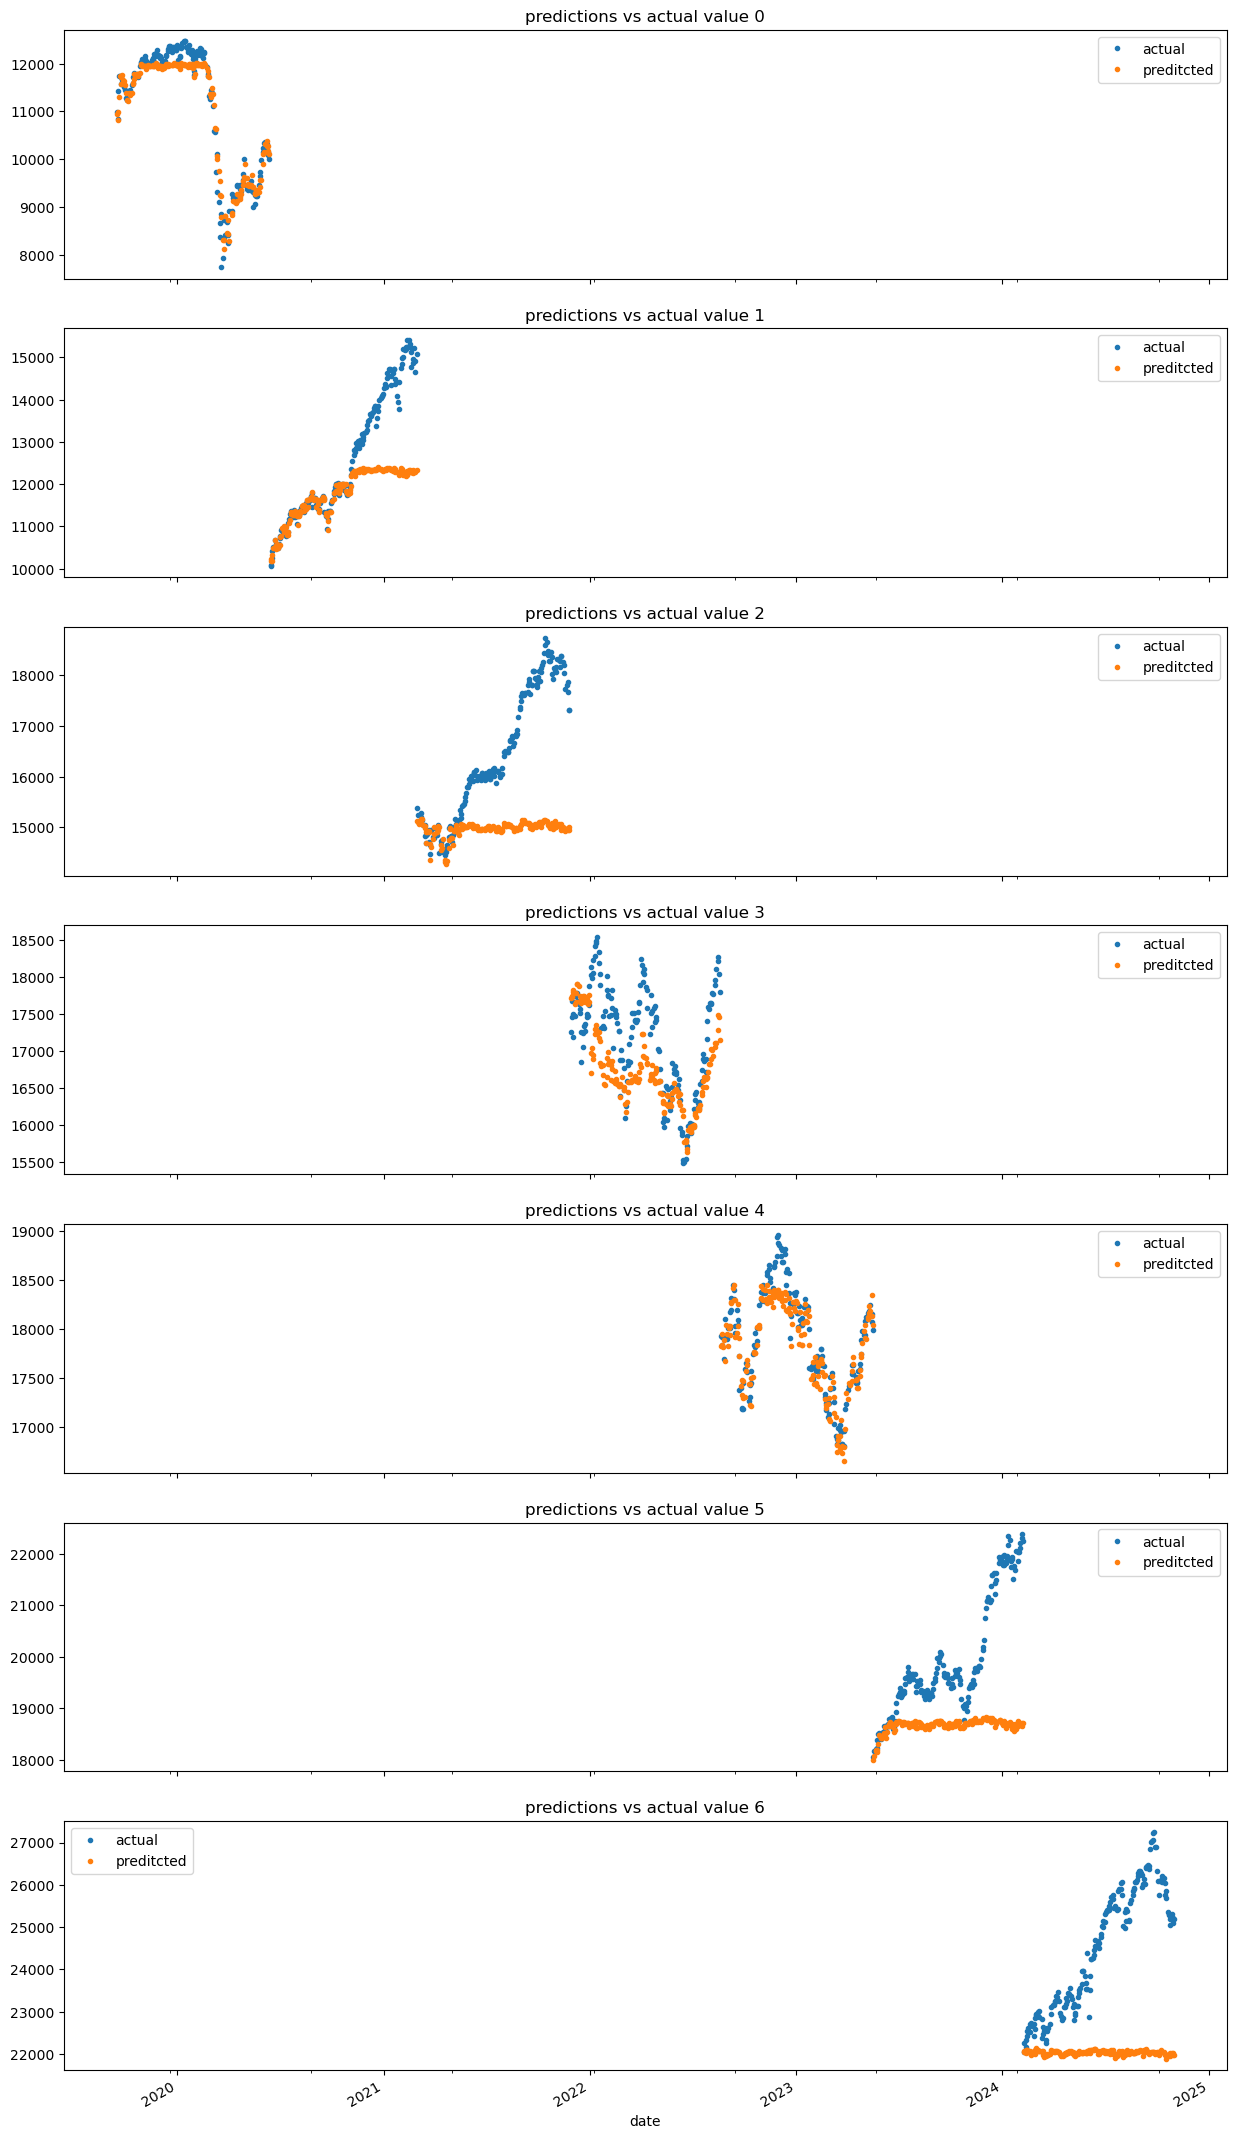

In [324]:
preds = []
scores = []
fold  = 0
fig, axs = plt.subplots(7,1,figsize=(15,30),
                      sharex = True
                       )

for train_idx, val_idx in splits[:-1]: #Exclude the last fold, it will be used for testing
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    #train = create_features(train)
    #test = create_features(test)

    FEATURES = ['open', 'close', 'close_diff_1', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'close(-1)', 'SMA',
       'EMA', 'MACD', 'RSI', 'H_L_diff', 'Bands_diff']
    TARGET = ['target']
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    '''
    model = xgb.XGBRegressor(
        base_score = 0.5,
        n_estimators = 1000,
        booster = 'gbtree',
        early_stopping_rounds = 50,
        objective = 'reg:linear',
        max_depth = 3,
        learning_rate = 0.01)
        '''

    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=5000,          # large + early stopping chooses best
        early_stopping_rounds = 50,
        max_depth=3,
        min_child_weight=10,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,              # L1
        reg_lambda=1.0,             # L2
        gamma=0.0,                  # min split loss
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        learning_rate = 0.01
    )
    
    model.fit(X_train, y_train,
             eval_set = [(X_train, y_train), (X_test, y_test)],
              verbose = 100
             )
    y_pred = model.predict(X_test)
    preds.append(y_pred)
    score = root_mean_squared_error(y_test, y_pred)
    scores.append(score)
    test['target'].plot(ax = axs[fold],
                      style = '.', 
                       title = f'predictions vs actual value {fold}'
   )
    y_preds_series = pd.Series(y_pred, index = test.index)
    y_preds_series.plot(ax = axs[fold],
                  style = '.', 
    )
    axs[fold].legend(["actual", "preditcted"])
    fold+=1
plt.show()

In [326]:
np.mean(scores)

1266.1041630336217

In [328]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,          # large + early stopping chooses best
    early_stopping_rounds = 20,
    max_depth=3,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,              # L1
    reg_lambda=1.0,             # L2
    gamma=0.0,                  # min split loss
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    learning_rate = 0.01
)

In [344]:
test_full = test_full.dropna(subset = ['target'])
X_train = train_full[FEATURES]
y_train = train_full[TARGET]

X_test = test_full[FEATURES]
y_test = test_full[TARGET]


In [346]:
model.fit(X_train, y_train,
             eval_set = [(X_train, y_train)],
              verbose = 100
             )

[0]	validation_0-rmse:4865.60342
[100]	validation_0-rmse:1833.56854
[200]	validation_0-rmse:705.90310
[300]	validation_0-rmse:296.50975
[400]	validation_0-rmse:165.44489
[500]	validation_0-rmse:131.66454
[600]	validation_0-rmse:123.02802
[700]	validation_0-rmse:119.66738
[800]	validation_0-rmse:117.55506
[900]	validation_0-rmse:115.75433
[999]	validation_0-rmse:114.28201


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,None


In [348]:
preds_final = model.predict(X_test)

In [350]:
root_mean_squared_error(preds_final,y_test)

362.9828796386719

<Axes: title={'center': 'predictions vs actual value 7'}, xlabel='date'>

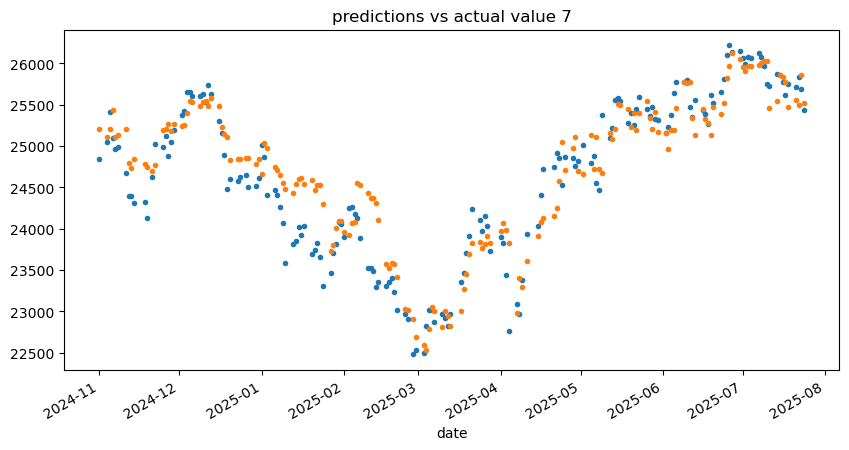

In [354]:
y_test['target'].plot( style = '.', 
                       title = f'predictions vs actual value {fold}'
   )
preds_series = pd.Series(preds_final, index = y_test.index)
preds_series.plot(style = '.', 
)

In [352]:
y_test

,target
date,
2024-11-01,24848.60
2024-11-04,25042.75
2024-11-05,25416.80
2024-11-06,25102.00
2024-11-07,24959.65
...,...
2025-07-18,25749.85
2025-07-21,25709.70
2025-07-22,25837.10
